In [2]:
import gc
import cudf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.metrics import r2_score
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, RuntimeWarning))

/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.B

In [3]:
# using giba's dataset since it's already in parquet format
# Dataset: https://www.kaggle.com/datasets/titericz/leap-dataset-giba
# This dataset was created using all train and test data.
# Train is 10M samples and was split in 17 parquet files. Test is a single parquet file.
data_path = Path("/kaggle/input/leap-atmospheric-physics-ai-climsim")  # ./data
train_file = data_path / "train.csv"
test_file  = data_path / "test.csv"

In [4]:
train = pd.read_csv(train_file, nrows=1, usecols=lambda x: x != "sample_id").astype('float32')
# will be useful later when we need to load it in chunks
dtype_dict = {col: 'float64' if col != 'sample_id' else 'object' for col in [*train.columns, 'sample_id']}
train_file_lines = 1e7  # we know we have approx 10mm lines
train.head()

,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,213.806122,222.244461,229.259872,245.743958,258.337494,265.772461,263.978455,254.879868,243.946152,236.706985,...,-6.132148e-07,0.000001,0.0,349.564331,0.0,2.947672e-12,0.0,0.0,0.0,0.0


# Utils

In [42]:
# because python doesn't have a builtin flatmap for some reason
def flatmap(func, iterables):
    return [item for iter in iterables for item in func(iter)]


target_scalars = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]

target_vectors_base = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]


def concat60(base):
    return [f"{base}_{i}" for i in range(60)]


# concat the 60 levels
target_vectors = flatmap(concat60, target_vectors_base)

target_cols = target_scalars + target_vectors


feat_scalars = [
    "state_ps",
    "pbuf_SOLIN",
    "pbuf_LHFLX",
    "pbuf_SHFLX",
    "pbuf_TAUX",
    "pbuf_TAUY",
    "pbuf_COSZRS",
    "cam_in_ALDIF",
    "cam_in_ALDIR",
    "cam_in_ASDIF",
    "cam_in_ASDIR",
    "cam_in_LWUP",
    "cam_in_ICEFRAC",
    "cam_in_LANDFRAC",
    "cam_in_OCNFRAC",
    "cam_in_SNOWHLAND",
]


feat_vectors_base = [
    "state_t",
    "state_q0001",
    "state_q0002",
    "state_q0003",
    "state_u",
    "state_v",
    "pbuf_ozone",
    "pbuf_CH4",
    "pbuf_N2O",
]

feat_vectors = flatmap(concat60, feat_vectors_base)

feat_cols = feat_scalars + feat_vectors

def compute_r2(y_valid, valid_preds, verbose=True):
    r2_scores = {}
    fn = tqdm if verbose else lambda x: x
    for i, col in fn(enumerate(target_cols)):
        r2_scores[col] = r2_score(y_valid[:, i], valid_preds[:, i])
    return r2_scores

# Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ChainDataset, IterableDataset
from torchmetrics.functional import r2_score as r2_loss

### GPU setup

In [7]:
if torch.cuda.is_available():
    print("GPU available")
    device = torch.device("cuda")  # Use GPU
else:
    print("GPU not available")
    device = torch.device("cpu")

GPU available


In [8]:
input_size  = len(feat_cols)  # number of input features
output_size = len(target_cols)  # number of output features

In [50]:
class TabularModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularModel, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

## Data processing

In [51]:
class CustomDataset(IterableDataset):
    def __init__(self, path, batch_size, feat_cols, target_cols, max_lines, start=0):
        self.batch_size = batch_size
        self.feat_cols = feat_cols
        self.target_cols = target_cols
        self.path = path
        self.start = int(start)
        self.max = max_lines
        self.idx = 0
        #self.header = pd.read_csv(self.path, sep=',', nrows=1)
    
    def __iter__(self):
        verbose = False
        if verbose: print('starting iter')
        with pd.read_csv(self.path, sep=',', chunksize=self.batch_size, skiprows=range(1, self.start), iterator=True) as reader:
            for chunk in reader:
                if verbose: print('read done')
                self.idx += self.batch_size
                #if self.idx < self.start:
                #    if self.idx % 1e4 < self.batch_size:
                #        print('skip at', self.idx)
                #    continue
                if self.idx > self.max:
                    break
                X_batch = chunk[self.feat_cols].astype('float32')
                y_batch = chunk[self.target_cols].astype('float32')
                if verbose: print('indexing done')
                if verbose: print(X_batch.shape)
                feat, target = (X_batch.values), (y_batch.values)
                yield feat, target
        #for x, y in ds:
        #    yield x, y
        #print(X_batch.values.shape)
        #yield X_batch.values, y_batch.values

In [61]:
batch_size = 2048
learning_rate = 0.005


# only using 30% of lines
train_lines = train_file_lines * 0.065

dataset = CustomDataset(train_file, batch_size, feat_cols, target_cols, max_lines=train_lines)
# since the bottleneck is using pandas to read chunks of the file, we do the batching at the dataset level
dataloader = DataLoader(dataset, batch_size=None, num_workers=4)
model = TabularModel(input_size, output_size).to(device)

## Training loop

In [62]:
# loss function and optimizer
criterion = nn.MSELoss()  #r2_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [63]:
num_epochs = 10

# history
train_losses = []
train_r2_scores = []

for epoch in tqdm(range(num_epochs)):
    y_pred = []
    y_true = []
    epoch_losses = []
    
    model.train()
    
    for X_batch, y_batch in dataloader:
        # Move batch to GPU if available
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # r2 loss (higher is better)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()

        optimizer.step()
                
        # save for end of epoch score computation
        y_pred.append(outputs.detach().cpu().numpy())
        y_true.append(y_batch.detach().cpu().numpy())
        epoch_losses.append(loss.item())

    # Compute R2 score
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    train_r2 = compute_r2(y_true, y_pred, verbose=False)

    train_r2_scores.append(train_r2)
    loss = np.mean(epoch_losses)
    train_losses.append(loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


 10%|█         | 1/10 [07:16<1:05:26, 436.25s/it]

Epoch [1/10], Loss: 36.3082


 20%|██        | 2/10 [14:04<55:57, 419.63s/it]  

Epoch [2/10], Loss: 23.5356


 30%|███       | 3/10 [20:36<47:29, 407.07s/it]

Epoch [3/10], Loss: 19.4505


 40%|████      | 4/10 [26:35<38:48, 388.03s/it]

Epoch [4/10], Loss: 17.4391


 50%|█████     | 5/10 [32:34<31:28, 377.67s/it]

Epoch [5/10], Loss: 16.1351


 60%|██████    | 6/10 [38:57<25:18, 379.58s/it]

Epoch [6/10], Loss: 14.8840


 70%|███████   | 7/10 [45:33<19:14, 384.79s/it]

Epoch [7/10], Loss: 14.1064


 80%|████████  | 8/10 [52:20<13:04, 392.00s/it]

Epoch [8/10], Loss: 13.4731


 90%|█████████ | 9/10 [58:38<06:27, 387.51s/it]

Epoch [9/10], Loss: 13.0172


100%|██████████| 10/10 [1:05:08<00:00, 390.82s/it]

Epoch [10/10], Loss: 12.6109


# Prediction

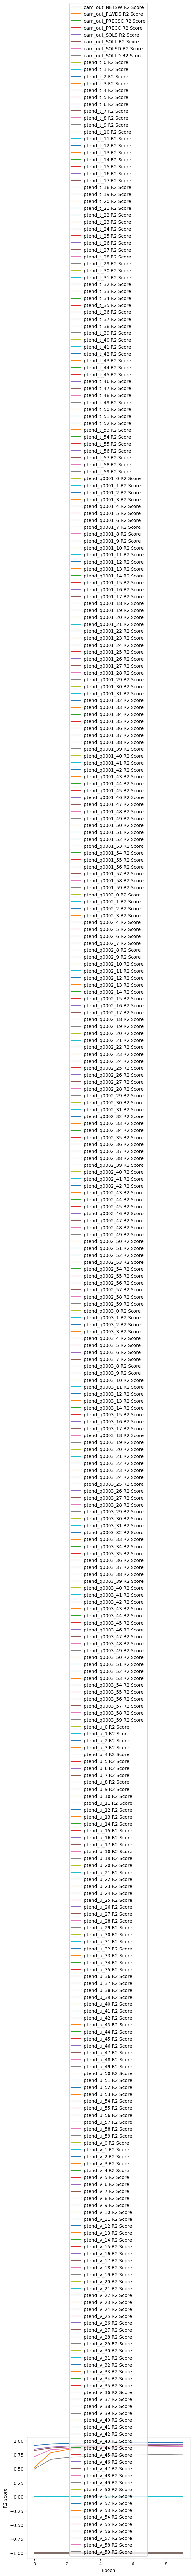

In [65]:
import matplotlib.pyplot as plt

#plt.plot(train_losses, label='Train Loss')
r2 = pd.DataFrame(train_r2_scores).clip(lower=-1)
for c in r2.columns:
    plt.plot(r2[c], label=f"{c} R2 Score")
plt.xlabel('Epoch')
plt.ylabel('R2 score')
plt.legend()
plt.show()

In [66]:
valid_lines = int(train_file_lines * 0.05)
valid_dataset = CustomDataset(train_file, 16_000, feat_cols, target_cols, max_lines=valid_lines+lines, start=lines)
# since the bottleneck is using pandas to read chunks of the file, we do the batching at the dataset level
valid_dataloader = DataLoader(valid_dataset, batch_size=None, num_workers=4)

In [67]:
lines, valid_lines+lines

(65000.0, 565000.0)

In [129]:
for tr, ts in valid_dataset:
    print(tr.shape)
    break

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
r2_arr = []

with torch.no_grad():
    for i, (X_batch, y_batch) in tqdm(enumerate(valid_dataloader)):
        if i > 30: break
        #print('got batch')
        X_batch = X_batch.to(device)
        valid_preds = model(X_batch).cpu().detach().numpy()
        #print('got preds', valid_preds.shape)
        
        r2 = compute_r2(y_batch, valid_preds)
        r2_arr.append(r2)


0it [00:00, ?it/s]

In [64]:
r2_scores = {}
for i, col in tqdm(enumerate(filtered_target_cols)):
    r2_scores[col] = r2_score(y_valid[:, i], valid_preds[col])

302it [00:04, 71.42it/s]


In [27]:
r2_scores = pd.DataFrame(r2_arr).mean()

In [29]:
pd.DataFrame(r2_arr)

,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD,ptend_t_0,ptend_t_1,...,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59
0,0.954675,0.870127,-5.254902e+15,-4.791161e+11,0.914700,0.897249,0.861991,0.686615,-9.106772e+06,-1.347901e+08,...,-7.297194e+08,-303849.587531,-1.144875e+07,-6.750329e+07,-1.199295e+07,-1.141373e+06,-3.206324e+08,-1.787886e+06,-2.628704e+07,-1.242110e+08
1,0.954046,0.869535,-5.261474e+15,-4.796535e+11,0.913166,0.895347,0.861953,0.686715,-9.118992e+06,-1.349164e+08,...,-7.304268e+08,-300082.783573,-1.150751e+07,-6.744006e+07,-1.200354e+07,-1.150071e+06,-3.209853e+08,-1.792338e+06,-2.627844e+07,-1.244934e+08
2,0.954814,0.868771,-5.267897e+15,-4.766230e+11,0.914253,0.896148,0.860834,0.682046,-9.069015e+06,-1.351120e+08,...,-7.314821e+08,-299280.930309,-1.142127e+07,-6.719016e+07,-1.193930e+07,-1.163015e+06,-3.214641e+08,-1.814317e+06,-2.617844e+07,-1.246678e+08
3,0.954206,0.870780,-5.254861e+15,-4.810408e+11,0.913665,0.895984,0.864369,0.687342,-9.135960e+06,-1.348284e+08,...,-7.297416e+08,-302144.302183,-1.155631e+07,-6.754871e+07,-1.203009e+07,-1.161786e+06,-3.207456e+08,-1.802621e+06,-2.632156e+07,-1.243020e+08
4,0.947549,0.862916,-3.689109e+15,-4.686263e+11,0.893620,0.877948,0.831778,0.649624,-8.319613e+06,-1.308284e+08,...,-7.895348e+08,-332620.064432,-1.226015e+07,-7.100298e+07,-1.261099e+07,-1.022129e+06,-2.728169e+08,-1.628485e+06,-2.883486e+07,-1.060543e+08
5,0.947630,0.861421,-3.695540e+15,-4.666183e+11,0.894390,0.879784,0.832869,0.652395,-8.302093e+06,-1.310460e+08,...,-7.908555e+08,-328200.185516,-1.223279e+07,-7.094074e+07,-1.257181e+07,-1.030424e+06,-2.732860e+08,-1.644946e+06,-2.877368e+07,-1.062644e+08
6,0.948103,0.863740,-3.680373e+15,-4.666494e+11,0.894372,0.878676,0.831726,0.650648,-8.299517e+06,-1.304914e+08,...,-7.876034e+08,-329863.316996,-1.219644e+07,-7.079824e+07,-1.256339e+07,-1.022057e+06,-2.721247e+08,-1.633469e+06,-2.874911e+07,-1.058040e+08
7,0.946726,0.860402,-3.684475e+15,-4.649623e+11,0.893321,0.877683,0.830786,0.650083,-8.276134e+06,-1.306475e+08,...,-7.884873e+08,-329750.818536,-1.211660e+07,-7.075896e+07,-1.253061e+07,-1.022841e+06,-2.724576e+08,-1.634435e+06,-2.869089e+07,-1.059221e+08
8,0.930338,0.845508,-3.193110e+15,-5.302132e+11,0.860926,0.840278,0.820790,0.627095,-7.419468e+06,-1.267241e+08,...,-1.033401e+09,-396784.074079,-1.352203e+07,-8.358654e+07,-1.434429e+07,-1.040527e+06,-2.533597e+08,-1.574699e+06,-2.757554e+07,-1.262970e+08
9,0.930825,0.847401,-3.190084e+15,-5.313797e+11,0.860573,0.840185,0.817291,0.620846,-7.435991e+06,-1.266247e+08,...,-1.032596e+09,-394894.360861,-1.349760e+07,-8.384574e+07,-1.437237e+07,-1.036730e+06,-2.531386e+08,-1.576586e+06,-2.765059e+07,-1.260807e+08


In [ ]:
plt.figure(figsize=(16, 5))
plt.grid()
for ft in target_scalars:
    plt.bar(target_scalars, [r2_scores[col] for col in target_scalars])
for col in target_scalars:
    print(f"{col} : {r2_scores[col]}")

In [ ]:
ss = pd.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", nrows=1).drop(['sample_id'], axis=1)
ss

In [ ]:
for col in target_vectors_base:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(60), [r2_scores[f"{col}_{i}"] for i in range(60)])
    plt.scatter(range(60), [(ss[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)], alpha=0.5)
    plt.title(f"{col}, 60 values")
    plt.grid()
    plt.legend(["R2 scores", "ss_weight != 0"])
    plt.ylim(0, 1)

# Write submission file

In [68]:
weights = pd.read_csv(f"/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", nrows=1)
weights = weights.drop(['sample_id'], axis=1).T.to_dict()[0]

In [ ]:
set(filtered_target_cols) - set(test_preds.columns)

In [69]:
submission = pd.read_csv(f"/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

for col in tqdm(filtered_target_cols):
    if weights[col] > 0:
        submission[col] = test_preds[col].values
    else:
        submission[col] = 0.
        
submission.to_csv('/kaggle/working/submission.csv', index=False)        
submission.head()

  0%|          | 0/302 [00:00<?, ?it/s]


NameError: name 'test_preds' is not defined